In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from hessian_eigenthings.power_iter import Operator, deflated_power_iteration
from hessian_eigenthings.lanczos import lanczos
from lanczos_generalized import lanczos_generalized
from GAN_hvp_operator import GANHVPOperator, GANForwardHVPOperator, compute_hessian_eigenthings

In [2]:
import numpy as np
import matplotlib.pylab as plt
from time import time
from os.path import join
from os import makedirs
from imageio import imwrite
from build_montages import build_montages, color_framed_montages

In [3]:
# #    Perceptual Similarity Net
#      Gan
#      alexnet or VGG
import sys
sys.path.append(r"E:\Github_Projects\PerceptualSimilarity")
sys.path.append(r"D:\Github\PerceptualSimilarity")
import models
model_squ = models.PerceptualLoss(model='net-lin', net='squeeze', use_gpu=1, gpu_ids=[0])
model_squ.requires_grad_(False).cuda()

from GAN_utils import upconvGAN
G = upconvGAN("fc6")
G.requires_grad_(False).cuda() # this notation is incorrect in older pytorch

import torchvision as tv
# VGG = tv.models.vgg16(pretrained=True)
alexnet = tv.models.alexnet(pretrained=True).cuda()
for param in alexnet.parameters():
    param.requires_grad_(False)

Setting up Perceptual loss...
Loading model from: E:\Github_Projects\PerceptualSimilarity\models\weights\v0.1\squeeze.pth
...[net-lin [squeeze]] initialized
...Done


In [9]:
from FeatLinModel import FeatLinModel, get_model_layers
from GAN_Metric_Hess_decomp import tuning_plot, get_full_hessian
from torchvision.transforms import Normalize, Compose

In [14]:
from collections import OrderedDict
class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = None

    def hook_fn(self, module, input, output):
        self.module = module
        self.features = output

    def close(self):
        self.hook.remove()

def hook_model(model, layerrequest = None):
    features = OrderedDict()
    alllayer = layerrequest is None
    # recursive hooking function
    def hook_layers(net, prefix=[]):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():
                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue
                cur_layername = "_".join(prefix + [name])
                if alllayer:
                    features[cur_layername] = ModuleHook(layer)
                elif not alllayer and cur_layername in layerrequest:
                    features[cur_layername] = ModuleHook(layer)
                hook_layers(layer, prefix=prefix + [name])

    hook_layers(model)

    def hook(layer):
        # if layer == "input":
        #     return image
        if layer == "labels":
            return list(features.values())[-1].features
        return features[layer].features

    return hook, features

def get_model_layers(model, getLayerRepr=False):
    layers = OrderedDict() if getLayerRepr else []
    # recursive function to get layers
    def get_layers(net, prefix=[]):
        if hasattr(net, "_modules"):
            for name, layer in net._modules.items():
                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue
                if getLayerRepr:
                    layers["_".join(prefix+[name])] = layer.__repr__()
                else:
                    layers.append("_".join(prefix + [name]))
                get_layers(layer, prefix=prefix+[name])

    get_layers(model)
    return layers

def FeatLinModel(VGG, layername='features_20', type="weight", weight=None, chan=0, pos=(10, 10)):
    """A factory of linear models on a pretrained CNN.
    It's a scorer of image. """
    layers_all = get_model_layers(VGG)
    if 'features' in layername:
        layeridx = layers_all.index(layername) - 1 + 1 # -1 for the "features" layer
        VGGfeat = VGG.features[:layeridx]
    else:
        VGGfeat = VGG
    hooks, feat_dict = hook_model(VGG, layerrequest=(layername,))
    layernames = list(feat_dict.keys())
    print(layernames)
    if type == "weight":
        def weight_objective(img, scaler=True):
            VGGfeat.forward(img.cuda())
            feat = hooks(layername)
            if scaler:
                return -(feat * weight.unsqueeze(0)).mean()
            else:
                batch = img.shape[0]
                return -(feat * weight.unsqueeze(0)).view(batch, -1).mean(axis=1)

        return weight_objective
    elif type == "neuron":
        def neuron_objective(img, scaler=True):
            VGGfeat.forward(img.cuda())
            feat = hooks(layername)
            if len(feat.shape) == 4:
                if scaler:
                    return -(feat[:, chan, pos[0], pos[1]]).mean()
                else:
                    batch = img.shape[0]
                    return -(feat[:, chan, pos[0], pos[1]]).view(batch, -1).mean(axis=1)
            elif len(feat.shape) == 2:
                if scaler:
                    return -(feat[:, chan]).mean()
                else:
                    batch = img.shape[0]
                    return -(feat[:, chan]).view(batch, -1).mean(axis=1)
        return neuron_objective

In [64]:
def eig_hist_ylog(eigvals, eigvals_u, savedir="", namestr="", RND=None, show=True):
    if RND is None: RND = np.random.randint(100)
    fig = plt.figure()
    plt.hist(eigvals_u, log=True, label="random", bins=30, alpha=0.5)
    plt.hist(eigvals, log=True, label="optimized", bins=30, alpha=0.5)
    # plt.xscale('log')
    plt.legend()
    plt.savefig(join(savedir, "eig_hist_ylog_%s_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    return fig

def eig_hist_xlog(eigvals, eigvals_u, savedir="", namestr="", RND=None, show=True):
    if RND is None: RND = np.random.randint(100)
    fig = plt.figure()
    _, bins = np.histogram(np.log10(np.abs(eigvals_u)[np.abs(eigvals_u) > 1E-10]), bins=30)
    plt.hist(np.abs(eigvals_u), bins=10**bins, log=False, label="random", alpha=0.5)
    _, bins = np.histogram(np.log10(np.abs(eigvals)[np.abs(eigvals) >  1E-10]), bins=30)
    plt.hist(np.abs(eigvals), bins=10**bins, log=False, label="optimized", alpha=0.5)
    plt.xscale('log')
    plt.legend()
    plt.savefig(join(savedir, "eig_hist_xlog_%s_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    return fig

def eig_vhv_sacatter(eigvals, vHv_arr, savedir="", namestr="", RND=None, show=True):
    if RND is None:
        RND = np.random.randint(100)
    fig = plt.figure()
    plt.scatter((np.abs(eigvals)), (np.abs(vHv_arr)))
    plt.xlabel("Eigenvalue of Activation function")
    plt.ylabel("vHv of metric function")
    plt.title("Relation between Eigen value of Activation and vHv for Metric\nfor %s"% namestr)
    plt.savefig(join(savedir, "Activ-vHv-Ratio_%s_lin_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    #%
    fig2 = plt.figure()
    plt.scatter(np.log10(np.abs(eigvals)), np.log10(np.abs(vHv_arr)))
    plt.xlabel("Eigenvalue of Activation function (log)")
    plt.ylabel("vHv of metric function (log)")
    plt.title("Relation between Eigen value of Activation and vHv for Metric\nfor %s"% namestr)
    plt.savefig(join(savedir, "Activ-vHv-Ratio_%s_log_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    return fig, fig2

def eig_vhv_sacatter_cross(eigvals, vHv_arr, eigvals_u, vHv_arr_u, savedir="", namestr="", RND=None, show=True):
    if RND is None:
        RND = np.random.randint(100)
    fig = plt.figure()
    plt.scatter((np.abs(eigvals_u)), (np.abs(vHv_arr_u)), alpha=0.3, label="random")
    plt.scatter((np.abs(eigvals)), (np.abs(vHv_arr)), alpha=0.3, label="optimized")
    plt.xlabel("Eigenvalue of Activation function")
    plt.ylabel("vHv of metric function")
    plt.title("Relation between Eigen value of Activation and vHv for Metric\nfor %s"% namestr)
    plt.legend()
    plt.savefig(join(savedir, "Activ-vHv-Ratio_%s_xlin_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    #%
    fig2 = plt.figure()
    plt.scatter(np.log10(np.abs(eigvals_u)), np.log10(np.abs(vHv_arr_u)), alpha=0.2, label="random")
    plt.scatter(np.log10(np.abs(eigvals)), np.log10(np.abs(vHv_arr)), alpha=0.2, label="optimized")
    plt.xlabel("Eigenvalue of Activation function (log)")
    plt.ylabel("vHv of metric function (log)")
    plt.title("Relation between Eigen value of Activation and vHv for Metric\nfor %s"% namestr)
    plt.legend()
    plt.savefig(join(savedir, "Activ-vHv-Ratio_%s_xlog_%02d.jpg"%(namestr, RND)))
    if show: plt.show()
    return fig, fig2

In [ ]:
summary_dir = r"E:\OneDrive - Washington University in St. Louis\HessTune\HessDecomp_Method"
def tuning_plot(G, preprocess, objective, feat, eigvals, eigvects, eig_id_arr=(0, 1, 5, 10, 15, 20, 40, 60, 80,99,150,200,250,299,450),
        save_indiv=False, save_row=False, ticks=21, summary_dir=summary_dir, veclabel="eig", titlestr="",
        pad=24, cmap=plt.cm.viridis, RND=None):
    if RND is None: RND = np.random.randint(100)
    vec_norm = feat.norm().item()
    ref_vect = (feat / vec_norm).cpu().numpy()
    theta_arr_deg =  np.linspace(-90, 90, ticks) # np.arange(-5, 6)
    theta_arr = theta_arr_deg / 180 * np.pi
    img_list_all = []
    scores_col = [] # array version of scores
    scores_all = [] # list version of scores
    # eig_id_arr = [0, 1, 5, 10, 15, 20, 40, 60, 80,99,150,200,250,299,450]
    for eig_id in eig_id_arr: #,600,799]:
        # eig_id = 0
        perturb_vect = eigvects[eig_id,:]  # PC_vectors[1,:]
        codes_arc = np.array([np.cos(theta_arr),
                              np.sin(theta_arr) ]).T @ np.array([ref_vect, perturb_vect])
        norms = np.linalg.norm(codes_arc, axis=1)
        codes_arc = codes_arc / norms[:, np.newaxis] * vec_norm
        imgs = G.visualize(torch.from_numpy(codes_arc).float().cuda())
        scores = - objective(preprocess(imgs), scaler=False)
        scores_col.append(scores.cpu().numpy())
        scores_all.extend(scores.cpu().squeeze().tolist())
        npimgs = imgs.detach().cpu().permute([2, 3, 1, 0]).numpy()

        if save_indiv:
            for i in range(npimgs.shape[3]):
                angle = theta_arr_deg[i]
                imwrite(join(newimg_dir, "norm%d_%s%d_ang%d.jpg" % (vec_norm, veclabel, eig_id, angle)), npimgs[:, :, :, i])

        img_list = [npimgs[:, :, :, i] for i in range(npimgs.shape[3])]
        img_list_all.extend(img_list)
        if save_row:
            mtg1 = build_montages(img_list, [256, 256], [len(theta_arr), 1])[0]
            imwrite(join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, eig_id)), mtg1)
    mtg_all = build_montages(img_list_all, [256, 256], [len(theta_arr), int(len(img_list_all) // len(theta_arr))])[0]
    imwrite(join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, RND)), mtg_all)
    print("Write to ", join(summary_dir, "norm%d_%s_%d.jpg" % (vec_norm, veclabel, RND)))

    mtg_frm = color_framed_montages(img_list_all, [256, 256], [len(theta_arr), int(len(img_list_all) // len(theta_arr))], scores_all, pad=pad, cmap=cmap)[0]
    imwrite(join(summary_dir, "norm%d_%s_framed_%d.jpg" % (vec_norm, veclabel, RND)), mtg_frm)
    print("Write to ", join(summary_dir, "norm%d_%s_framed_%d.jpg" % (vec_norm, veclabel, RND)))

    scores_col = np.array(scores_col)
    plt.figure(figsize=[8,10])
    plt.matshow(scores_col)
    plt.axis('image')
    plt.title("Neural Tuning Towards Different Eigen Vectors of Activation")
    plt.xlabel("Angle")
    plt.ylabel("Eigen Vector #")
    eiglabel = ["%d %.3f"%(id,eig) for id, eig in zip(eig_id_arr, eigvals[eig_id_arr])]
    plt.yticks(range(len(eig_id_arr)), eiglabel) # eig_id_arr
    plt.ylim(top=-0.5, bottom=len(eig_id_arr) - 0.5)
    plt.colorbar()
    plt.suptitle(titlestr)
    plt.savefig(join(summary_dir, "norm%d_%s_score_mat_%02d.jpg" % (vec_norm, veclabel, RND)) )
    plt.show()
    print("Write to ", join(summary_dir, "norm%d_%s_score_mat_%02d.jpg" % (vec_norm, veclabel, RND)) )

In [59]:
get_model_layers(alexnet, getLayerRepr=True)
nametransl = {"conv1":'features_0', "conv2":'features_3', 'conv3':'features_6', 'conv4':'features_8', "conv5":'features_10', 'fc6':'classifier_1', 'fc7':'classifier_4', 'fc8':'classifier_6'}

In [60]:
RGB_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1).cuda()
preprocess = Compose([lambda img: (F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) - RGB_mean) / RGB_std])

['features_3']
130.7051501274109
295.46479177474976
step 9: -7.81
step 19: -25.91
step 29: -40.29
step 39: -55.77
step 49: -67.60
step 59: -77.33
step 69: -83.03
step 79: -87.38
step 89: -90.01
step 99: -91.20
step 109: -93.82
step 119: -95.62
step 129: -97.24
step 139: -99.43
step 149: -100.79
step 159: -102.26
step 169: -103.43
step 179: -104.19
step 189: -104.82
step 199: -105.28
131.24183535575867
296.7600185871124
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet\norm318_conv2_0_(13_13)_opt_eig_51.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet\norm318_conv2_0_(13_13)_opt_eig_framed_51.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet\norm318_conv2_0_(13_13)_opt_eig_score_mat_51.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet\norm312_conv2_0_(13_13)_un_eig_51.jpg
Write to  E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet\norm312_conv2_0_(13_13)_u

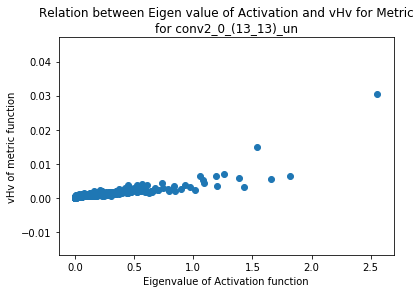

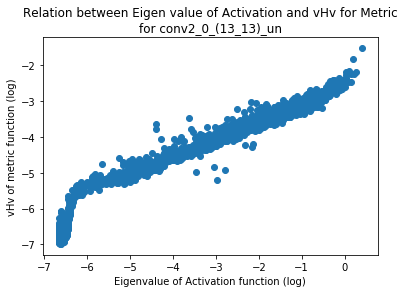

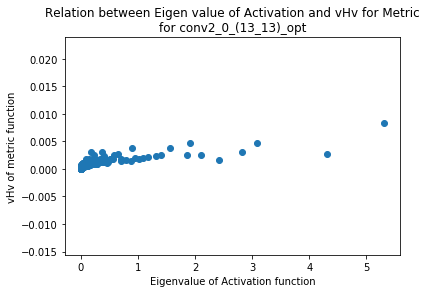

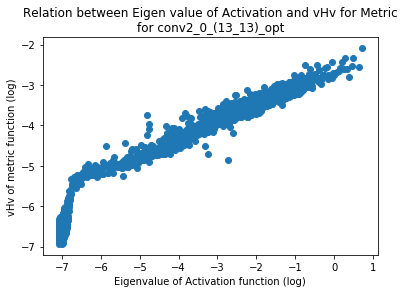

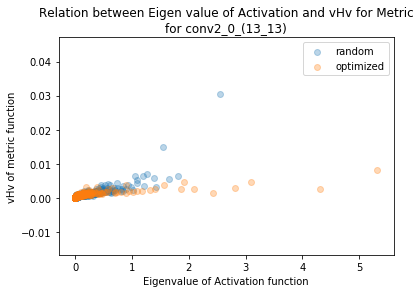

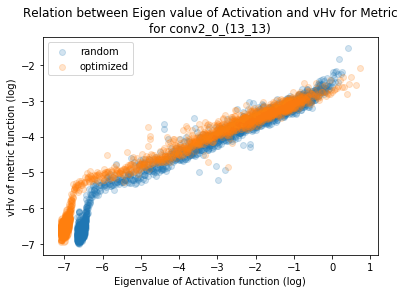

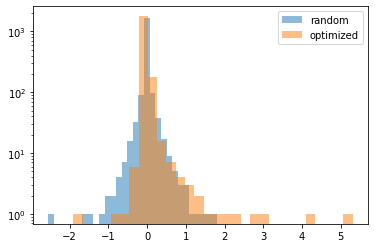

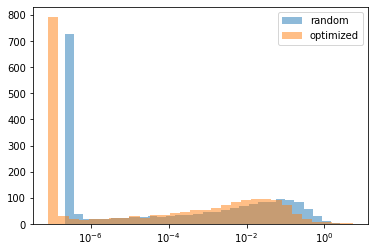

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

<Figure size 576x720 with 0 Axes>

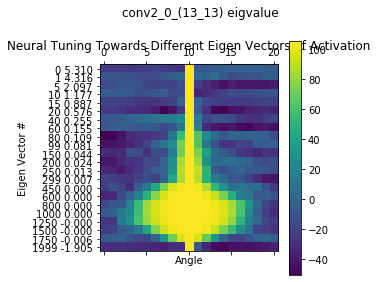

<Figure size 576x720 with 0 Axes>

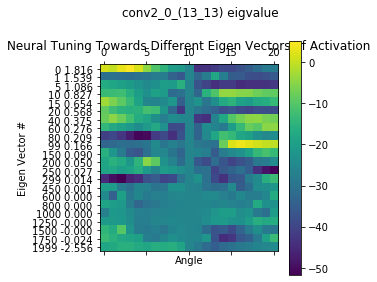

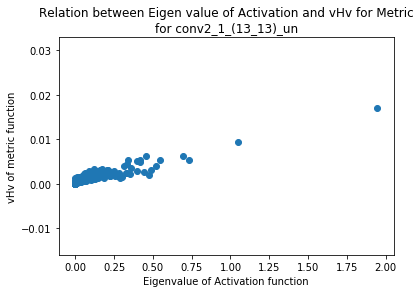

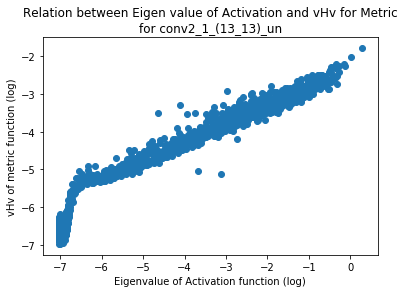

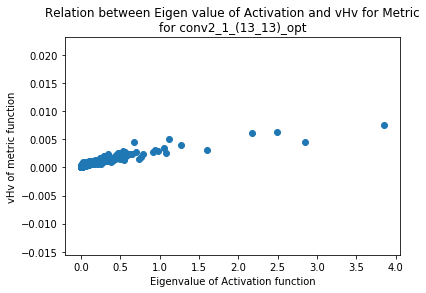

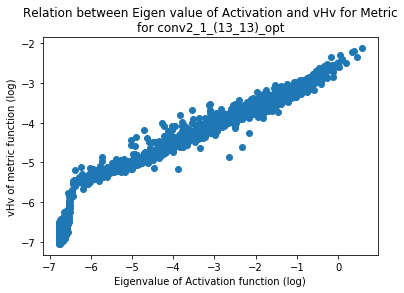

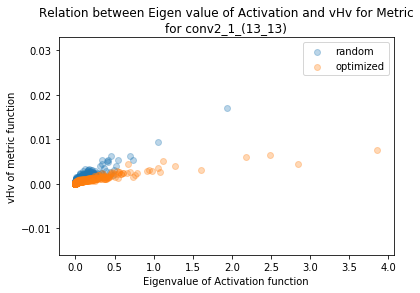

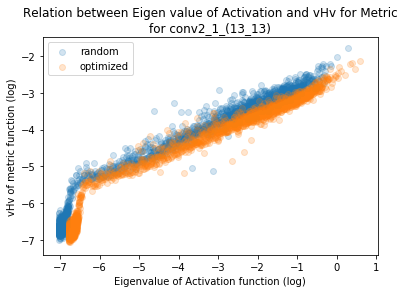

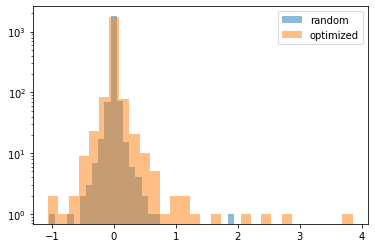

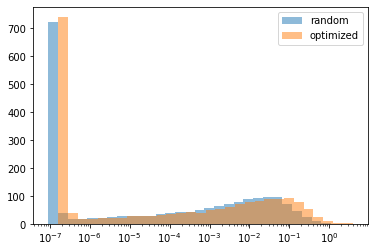

<Figure size 576x720 with 0 Axes>

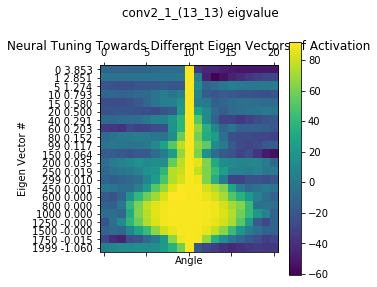

<Figure size 576x720 with 0 Axes>

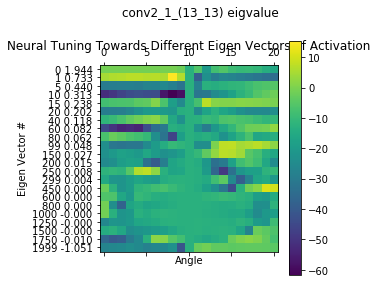

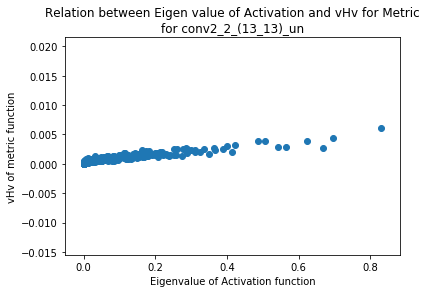

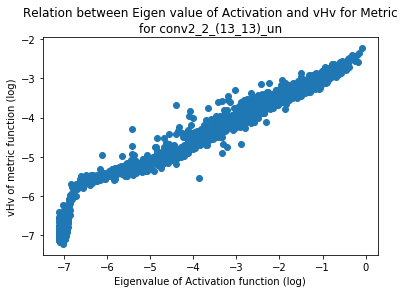

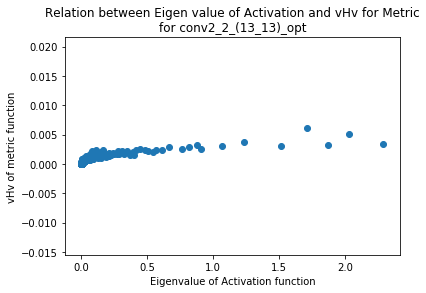

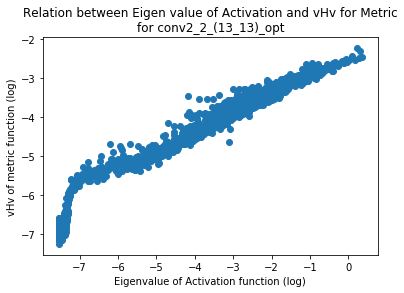

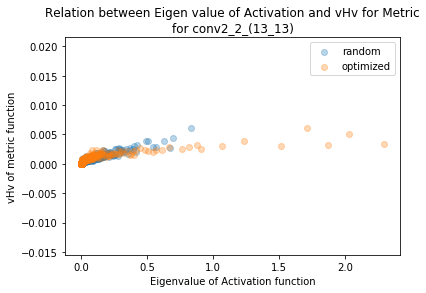

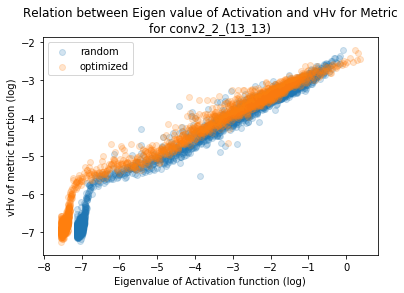

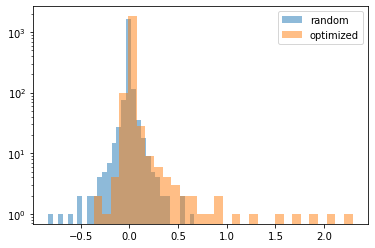

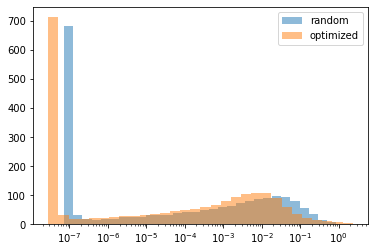

<Figure size 576x720 with 0 Axes>

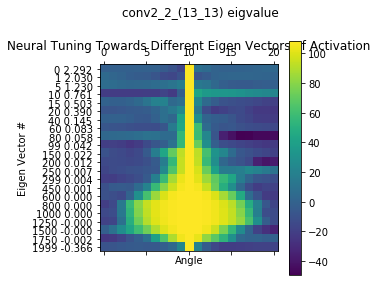

<Figure size 576x720 with 0 Axes>

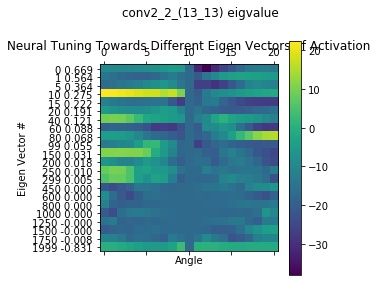

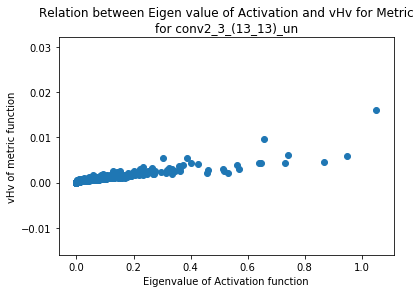

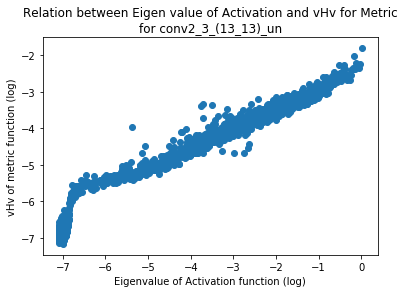

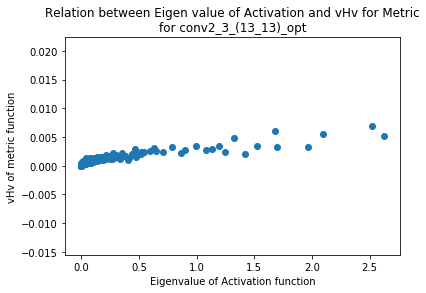

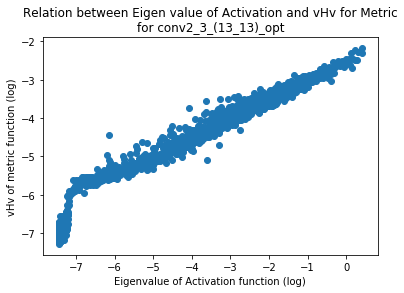

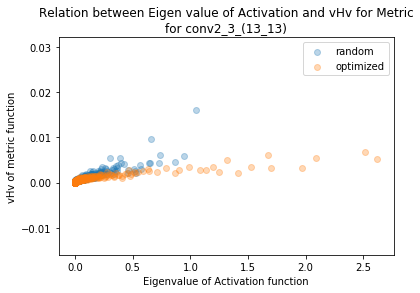

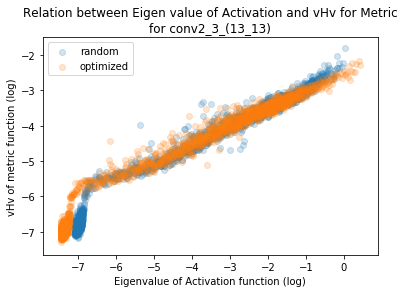

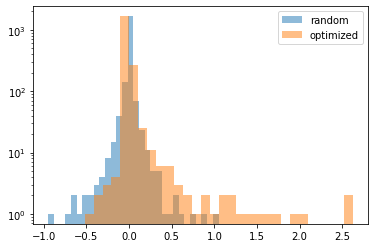

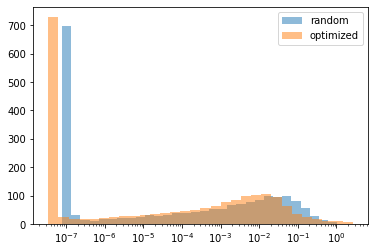

<Figure size 576x720 with 0 Axes>

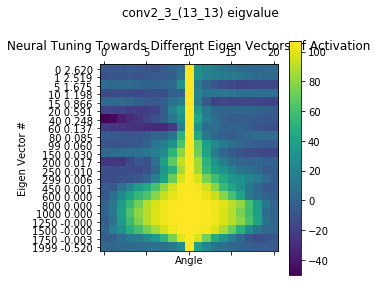

<Figure size 576x720 with 0 Axes>

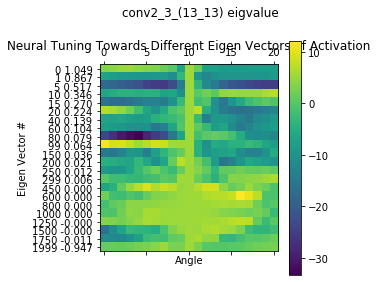

In [ ]:
%%time
save_dir = r"E:\OneDrive - Washington University in St. Louis\HessTune\AlexNet"

layername = "conv5"
pos = (10,10)
unitlist = [#("conv1", (27, 27)),
            ("conv2", (13, 13)),
            ("conv3", (6, 6)),
            ("conv4", (6, 6)),
            ("conv5", (6, 6)),
            ("fc6", (1, 1)),
            ("fc7", (1, 1)),
            ("fc8", (1, 1)),]
for layername, pos in unitlist:
    for chan in range(5):
        T0all = time()
        objective = FeatLinModel(alexnet, layername=nametransl[layername], type="neuron", chan=chan, pos=pos) # slice(None)
        feat = 5 * torch.randn(4096).cuda()
        feat_u = feat.detach().clone()
        #%
        activHVP = GANForwardHVPOperator(G, feat, objective, preprocess=preprocess)
        activHVP.apply(1*torch.randn(4096).requires_grad_(False).cuda())
        t0 = time()
        eigvals_u, eigvects_u = lanczos(activHVP, num_eigenthings=2000, use_gpu=True)
        print(time() - t0)  # 40 sec 146sec for 2000 eigens
        eigvals_u = eigvals_u[::-1]
        eigvects_u = eigvects_u[::-1, :]

        metricHVP = GANHVPOperator(G, feat, model_squ)
        vHv_arr_u = np.zeros_like(eigvals_u)
        vHv_arr_u.fill(np.nan)
        for i, vec in enumerate(eigvects_u):
            vHv_arr_u[i] = metricHVP.vHv_form(torch.tensor(vec).cuda())
        print(time() - t0)
        #%
        feat.requires_grad_(True)
        optimizer = optim.Adam([feat], lr=5e-2)
        for step in range(200):
            optimizer.zero_grad()
            obj = objective(preprocess(G.visualize(feat)))
            obj.backward()
            optimizer.step()
            if np.mod((step + 1), 10) == 0:
                print("step %d: %.2f"%(step, obj.item()))
        #%
        feat.requires_grad_(False)
        activHVP = GANForwardHVPOperator(G, feat, objective, preprocess=preprocess)
        activHVP.apply(1*torch.randn(4096).requires_grad_(False).cuda())

        t0 = time()
        eigvals, eigvects = lanczos(activHVP, num_eigenthings=2000, use_gpu=True)
        print(time() - t0)  # 40 sec 146sec for 2000 eigens
        eigvals = eigvals[::-1]
        eigvects = eigvects[::-1, :]

        metricHVP = GANHVPOperator(G, feat, model_squ)
        vHv_arr = np.zeros_like(eigvals)
        vHv_arr.fill(np.nan)
        for i, vec in enumerate(eigvects):
            vHv_arr[i] = metricHVP.vHv_form(torch.tensor(vec).cuda())
        print(time() - t0)
        #%
        np.savez(join(save_dir, "%s_%d_(%d_%d).npz"%(layername, chan, *pos)), eigvals_u=eigvals_u, eigvects_u=eigvects_u, vHv_arr_u=vHv_arr_u, feat_u=feat_u.cpu().numpy(),
         eigvals=eigvals, eigvects=eigvects, vHv_arr=vHv_arr, feat=feat.cpu().numpy())
        #%
        RND = np.random.randint(100)
        eig_vhv_sacatter(eigvals_u, vHv_arr_u, savedir=save_dir, namestr="%s_%d_(%d_%d)_un"%(layername, chan, *pos), RND=RND)
        eig_vhv_sacatter(eigvals, vHv_arr, savedir=save_dir, namestr="%s_%d_(%d_%d)_opt"%(layername, chan, *pos), RND=RND)
        eig_vhv_sacatter_cross(eigvals, vHv_arr, eigvals_u, vHv_arr_u, savedir=save_dir, namestr="%s_%d_(%d_%d)"%(layername, chan, *pos), RND=RND)
        try:
            eig_hist_ylog(eigvals, eigvals_u, savedir=save_dir, namestr="%s_%d_(%d_%d)"%(layername, chan, *pos), RND=RND)
            eig_hist_xlog(eigvals, eigvals_u, savedir=save_dir, namestr="%s_%d_(%d_%d)"%(layername, chan, *pos), RND=RND)
        except:
            print("xlog error")
            pass
        eig_id_arr = [0, 1, 5, 10, 15, 20, 40, 60, 80,99,150,200,250,299,450,600, 800, 1000, 1250, 1500, 1750, 1999]
        tuning_plot(G, preprocess, objective, feat, eigvals, eigvects, eig_id_arr, veclabel="%s_%d_(%d_%d)_opt_eig"%(layername, chan, *pos), titlestr="%s_%d_(%d_%d) eigvalue"%(layername, chan, *pos), summary_dir=save_dir, RND=RND)
        #%
        tuning_plot(G, preprocess, objective, feat_u, eigvals_u, eigvects_u, eig_id_arr, veclabel="%s_%d_(%d_%d)_un_eig"%(layername, chan, *pos), titlestr="%s_%d_(%d_%d) eigvalue"%(layername, chan, *pos), summary_dir=save_dir, RND=RND)
        print(time() - T0all, " finish one unit %s_%d_(%d_%d) eigvalue"%(layername, chan, *pos))

In [56]:
feat_u = feat.detach().clone()

In [ ]:
eig_id_arr = [0, 1, 5, 10, 15, 20, 40, 60, 80,99,150,200,250,299,450,600, 800, 1000, 1250, 1500, 1750, 1999]
tuning_plot(G, preprocess, objective, feat, eigvals, eigvects, eig_id_arr, veclabel="%s_%d_(%d_%d)_opt_eig"%(layername, chan, *pos), titlestr="%s_%d_(%d_%d) eigvalue"%(layername, chan, *pos), summary_dir=save_dir, RND=RND)
#%
tuning_plot(G, preprocess, objective, feat_u, eigvals_u, eigvects_u, eig_id_arr, veclabel="%s_%d_(%d_%d)_un_eig"%(layername, chan, *pos), titlestr="%s_%d_(%d_%d) eigvalue"%(layername, chan, *pos), summary_dir=save_dir, RND=RND)
print(time() - T0all, " finish one unit %s_%d_(%d_%d) eigvalue"%(layername, chan, *pos))